# Web scraping Spanish La-Liga fixtures and results: Cleaning and analyzing the data to predict match outcomes using RandomForestClassifier



In [175]:
# ** Dependencies **

# Importing necessary libraries for web scraping, data manipulation, and machine learning

import requests  # To handle HTTP requests to fetch web page content
from bs4 import BeautifulSoup  # To parse HTML and extract data from web pages
import pandas as pd  # For data manipulation and analysis, especially for reading HTML tables and managing dataframes
from io import StringIO  # To treat strings as file-like objects, useful for reading HTML content with pandas
import time  # To handle time-related tasks, such as pauses between requests to avoid overloading servers

# Importing necessary libraries for machine learning and model evaluation
from sklearn.ensemble import RandomForestClassifier  # To build a random forest model for classification tasks
from sklearn.metrics import accuracy_score  # To calculate the accuracy of the classification model
from sklearn.metrics import classification_report  # To generate a detailed report of classification metrics (precision, recall, f1-score, etc.)


# Importing necessary libraries for data visualization
import matplotlib.pyplot as plt  # To create static, animated, and interactive visualizations in Python
import seaborn as sns  # To create attractive and informative statistical graphics



In [176]:
# ** Stage 1: Scraping the Data **

# URL of the La-Liga statistics page to scrape
url = "https://fbref.com/en/comps/12/La-Liga-Stats"

# Send a GET request to the main page to retrieve the HTML content
data_1 = requests.get(url)

data_1  # This will show the status code, e.g., <Response [200]> if successful

<Response [200]>

In [177]:
# Create an instance of BeautifulSoup with the HTML content from the GET request
soup = BeautifulSoup(data_1.text, "html.parser")

# Display the parsed HTML content (optional, for debugging)
# print(soup.prettify()[:1000])  # Print the first 1000 characters of the parsed HTML

In [178]:
# Select the second 'table.stats_table' element from the HTML
league_table = soup.select('table.stats_table')[1]

In [179]:
# Find all 'a' (anchor) tags within the league table
links = league_table.find_all('a')

# Extract the href attributes from the links 
links = [l.get("href") for l in links]

# Filter to include only those containing '/squads/'
links = [l for l in links if '/squads/' in l]

# Print the first few links directly
for link in links[:3]:  # Adjust the number of links you want to print
    print(link)


/en/squads/53a2f082/2023-2024/Real-Madrid-Stats
/en/squads/206d90db/2023-2024/Barcelona-Stats
/en/squads/9024a00a/2023-2024/Girona-Stats


In [181]:
# Create full URLs for each team by appending the base URL to each link
team_urls = [f"https://fbref.com{l}" for l in links]

In [182]:
# List of full URLs for each team created by appending the base URL to each filtered link
team_urls

['https://fbref.com/en/squads/53a2f082/2023-2024/Real-Madrid-Stats',
 'https://fbref.com/en/squads/206d90db/2023-2024/Barcelona-Stats',
 'https://fbref.com/en/squads/9024a00a/2023-2024/Girona-Stats',
 'https://fbref.com/en/squads/db3b9613/2023-2024/Atletico-Madrid-Stats',
 'https://fbref.com/en/squads/2b390eca/Athletic-Club-Stats',
 'https://fbref.com/en/squads/e31d1cd9/Real-Sociedad-Stats',
 'https://fbref.com/en/squads/fc536746/Real-Betis-Stats',
 'https://fbref.com/en/squads/2a8183b3/Villarreal-Stats',
 'https://fbref.com/en/squads/dcc91a7b/Valencia-Stats',
 'https://fbref.com/en/squads/8d6fd021/Alaves-Stats',
 'https://fbref.com/en/squads/03c57e2b/Osasuna-Stats',
 'https://fbref.com/en/squads/7848bd64/Getafe-Stats',
 'https://fbref.com/en/squads/f25da7fb/Celta-Vigo-Stats',
 'https://fbref.com/en/squads/ad2be733/Sevilla-Stats',
 'https://fbref.com/en/squads/2aa12281/Mallorca-Stats',
 'https://fbref.com/en/squads/0049d422/Las-Palmas-Stats',
 'https://fbref.com/en/squads/98e8af82/Rayo

In [194]:
# Select one team URL for example purposes
team_url = team_urls[1] 

In [195]:
# Print the selected team URL
print(team_url)

https://fbref.com/en/squads/206d90db/2023-2024/Barcelona-Stats


In [196]:
# Send a GET request to the team page for just Barcelona using the previously selected team URL
data_2 = requests.get(team_url)

# Display the response object for the Barcelona team page (this will show the status of the request, optional)
data_2

<Response [200]>

In [197]:
# Parse the HTML content with BeautifulSoup
# Useful for investigating the structure of the HTML or extracting additional data if needed
soup_2 = BeautifulSoup(data_2.text, "html.parser")

# Find all tables in the parsed HTML
tables = soup_2.find_all('table')

# Print the captions of the tables to identify the correct one ("Scores & Fixtures")
for idx, table in enumerate(tables):
    caption = table.find('caption')
    if caption:
        print(f"Table {idx}: {caption.text}")  # Print the index and caption text to identify the tables
    else:
        print(f"Table {idx} has no caption")

Table 0: Standard Stats 2023-2024 Barcelona: La Liga Table
Table 1: Scores & Fixtures 2023-2024 Barcelona: All Competitions Table
Table 2: Goalkeeping 2023-2024 Barcelona: La Liga Table
Table 3: Advanced Goalkeeping 2023-2024 Barcelona: La Liga Table
Table 4: Shooting 2023-2024 Barcelona: La Liga Table
Table 5: Passing 2023-2024 Barcelona: La Liga Table
Table 6: Pass Types 2023-2024 Barcelona: La Liga Table
Table 7: Goal and Shot Creation 2023-2024 Barcelona: La Liga Table
Table 8: Defensive Actions 2023-2024 Barcelona: La Liga Table
Table 9: Possession 2023-2024 Barcelona: La Liga Table
Table 10: Playing Time 2023-2024 Barcelona: La Liga Table
Table 11: Miscellaneous Stats 2023-2024 Barcelona: La Liga Table
Table 12: La Liga, La Liga Table
Table 13: La Liga, La Liga Table


In [199]:
# use pandas to read in the tables 

# Wrap the HTML content of the team page (data_2.text) with the StringIO function 
# This allows the HTML data to be read by pandas as if it were a file
html_data = StringIO(data_2.text)

# Use pandas to read the HTML data and find the table that matches "Scores & Fixtures"
# This extracts the relevant table from the HTML content
matches = pd.read_html(html_data, match="Scores & Fixtures")


In [201]:
# Display the first few rows of the extracted table for "Scores & Fixtures" for the team
# [0] is used here to select the first table from a list of tables (even if there is only 1)
matches[0].head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,2023-08-13,21:30,La Liga,Matchweek 1,Sun,Away,D,0,0,Getafe,1.4,0.6,74,13410,Marc-André ter Stegen,4-2-3-1,César Soto,Match Report,NaN
1,2023-08-20,19:30,La Liga,Matchweek 2,Sun,Home,W,2,0,Cádiz,3.4,1.1,74,39603,Marc-André ter Stegen,3-4-3,Alejandro Muñíz,Match Report,NaN
2,2023-08-27,17:30,La Liga,Matchweek 3,Sun,Away,W,4,3,Villarreal,3.1,1.9,60,21679,Sergi Roberto,4-3-3,Alejandro Hernández,Match Report,NaN
3,2023-09-03,21:00,La Liga,Matchweek 4,Sun,Away,W,2,1,Osasuna,2.0,0.8,69,21966,Sergi Roberto,4-3-3,Miguel Ángel Ortiz Arias,Match Report,NaN
4,2023-09-16,21:00,La Liga,Matchweek 5,Sat,Home,W,5,0,Betis,2.4,0.8,65,45055,Marc-André ter Stegen,4-3-3,José Sánchez,Match Report,NaN


In [112]:
# This script scrapes the fixtures and results from multiple team URLs,
# processes the data, and combines it into a single CSV file. The script includes
# error handling and retries with exponential backoff for failed requests.

all_matches = []
skipped_urls = []

# Function to send a GET request with retries and exponential backoff
def get(url, max_retries=5, max_wait_time=60):
    wait_time = 1  # Initial wait time in seconds
    for i in range(max_retries):
        response = requests.get(url)
        if response.status_code == 200:
            return response
        elif response.status_code == 429:
            retry_after = int(response.headers.get("Retry-After", wait_time))
            print(f"Rate limit exceeded. Retrying after {retry_after} seconds.")
            if retry_after > max_wait_time:
                print(f"Retry after {retry_after} seconds is too long. Skipping {url}.")
                return None
            time.sleep(retry_after)
            wait_time = min(60, wait_time * 2)  # Exponential backoff
        else:
            print(f"Failed to get page, status code: {response.status_code}")
            return None
    return None

# Loop through each team URL to scrape data
for team_url in team_urls:
    # Extract team name from the URL
    team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
    response = get(team_url)

    if not response:
        print(f"Skipping {team_name} due to repeated get failures.")
        skipped_urls.append(team_url)
        continue

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Print the title to confirm it's the right page
    print(soup.title.string)

    # Find all tables with the class 'stats_table'
    tables = soup.find_all('table', {'class': 'stats_table'})
    print(f"Found {len(tables)} tables on {team_name} page")


    # Ensure that the matches variable is not empty, find caption in table make sure it contains 'scores & fixtures' 
    # then use pandas read_html function to assign the table to matches after it has been converted to string and an 
    # object, if matches empty then continue
    matches = None
    for idx, table in enumerate(tables):
        caption = table.find('caption')
        if caption and "Scores & Fixtures" in caption.text:
            print(f"Found 'Scores & Fixtures' table at index {idx}")
            matches = pd.read_html(StringIO(str(table)))[0]
            break

    if matches is None:
        print(f"Did not find 'Scores & Fixtures' table for {team_name}")
        continue

    # Assuming 'matches' contains the required table, display the first few rows
    print(matches.head())

    try:
        # Filter the matches for La Liga competition and add season and team name columns
        matches = matches[matches["Comp"] == "La Liga"]
        matches["Season"] = '2023-2024'
        matches["Team"] = team_name
        all_matches.append(matches)
    except Exception as e:
        print(f"Error processing matches for {team_name}: {e}")

    # Add a delay between requests to avoid rate limiting
    time.sleep(1)

# Combine all dataframes into one
if all_matches:
    all_matches_la_liga_2324 = pd.concat(all_matches, ignore_index=True)
    # Save the dataframe to a CSV file
    all_matches_la_liga_2324.to_csv('all_matches_la_liga_2324.csv', index=False)
    print("Data saved to all_matches_la_liga_2324.csv")
else:
    print("No data collected")

# Log the skipped URLs
if skipped_urls:
    print("The following URLs were skipped due to rate limits or other issues:")
    for url in skipped_urls:
        print(url)


Real Madrid Stats, La Liga | FBref.com
Found 14 tables on Real Madrid page
Found 'Scores & Fixtures' table at index 1
         Date   Time     Comp        Round  Day Venue Result GF GA  \
0  2023-08-12  21:30  La Liga  Matchweek 1  Sat  Away      W  2  0   
1  2023-08-19  19:30  La Liga  Matchweek 2  Sat  Away      W  3  1   
2  2023-08-25  21:30  La Liga  Matchweek 3  Fri  Away      W  1  0   
3  2023-09-02  16:15  La Liga  Matchweek 4  Sat  Home      W  2  1   
4  2023-09-17  21:00  La Liga  Matchweek 5  Sun  Home      W  2  1   

        Opponent   xG  xGA  Poss  Attendance        Captain   Formation  \
0  Athletic Club  0.9  0.4    54       48927  Dani Carvajal  4-1-2-1-2◆   
1        Almería  2.0  1.3    57       17561  Dani Carvajal     4-3-1-2   
2     Celta Vigo  1.4  1.2    63       23057  Dani Carvajal  4-1-2-1-2◆   
3         Getafe  2.8  0.4    76       66747    Luka Modrić     4-3-1-2   
4  Real Sociedad  2.0  1.6    52       70092  Dani Carvajal  4-1-2-1-2◆   

          

In [202]:
# The data has been collected and saved previously, so there is no need to scrape it again for this project.
# We will load the data from the CSV file into a new DataFrame and work with that.
la_liga_2324 = pd.read_csv('all_matches_la_liga_2324.csv')


In [203]:
# ** Stage 2: Data Integrity and Preparing for ML **
# Let's have a look at the first few rows of our DataFrame to understand its structure and content.
la_liga_2324.head()


,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Season,Team
0,2023-08-12,21:30,La Liga,Matchweek 1,Sat,Away,W,2,0,Athletic Club,...,0.4,54.0,48927.0,Dani Carvajal,4-1-2-1-2◆,Jesús Gil,Match Report,NaN,2023-2024,Real Madrid
1,2023-08-19,19:30,La Liga,Matchweek 2,Sat,Away,W,3,1,Almería,...,1.3,57.0,17561.0,Dani Carvajal,4-3-1-2,José Sánchez,Match Report,NaN,2023-2024,Real Madrid
2,2023-08-25,21:30,La Liga,Matchweek 3,Fri,Away,W,1,0,Celta Vigo,...,1.2,63.0,23057.0,Dani Carvajal,4-1-2-1-2◆,Isidro Díaz de Mera,Match Report,NaN,2023-2024,Real Madrid
3,2023-09-02,16:15,La Liga,Matchweek 4,Sat,Home,W,2,1,Getafe,...,0.4,76.0,66747.0,Luka Modrić,4-3-1-2,Mario Melero,Match Report,NaN,2023-2024,Real Madrid
4,2023-09-17,21:00,La Liga,Matchweek 5,Sun,Home,W,2,1,Real Sociedad,...,1.6,52.0,70092.0,Dani Carvajal,4-1-2-1-2◆,César Soto,Match Report,NaN,2023-2024,Real Madrid


In [204]:
# Let's have a look at rearranging the columns, and maybe drop some columns if they are not needed
# Get the list of current columns in the DataFrame
current_columns = la_liga_2324.columns.tolist()

# Display the list of current columns
current_columns


['Date',
 'Time',
 'Comp',
 'Round',
 'Day',
 'Venue',
 'Result',
 'GF',
 'GA',
 'Opponent',
 'xG',
 'xGA',
 'Poss',
 'Attendance',
 'Captain',
 'Formation',
 'Referee',
 'Match Report',
 'Notes',
 'Season',
 'Team']

In [205]:
# Take out 'Match Report' and 'Notes' columns and define the new order of columns
new_order = [
    'Comp',
    'Season',
    'Round',
    'Date',
    'Time',
    'Day',
    'Team',
    'Opponent',
    'Venue',
    'Result',
    'GF',
    'GA',
    'Poss',
    'Attendance',
    'Captain',
    'Formation',
    'Referee'
]


In [206]:
# Apply the new column order to the DataFrame
la_liga_2324 = la_liga_2324[new_order]

# Display the DataFrame with the new column order
la_liga_2324.head()


,Comp,Season,Round,Date,Time,Day,Team,Opponent,Venue,Result,GF,GA,Poss,Attendance,Captain,Formation,Referee
0,La Liga,2023-2024,Matchweek 1,2023-08-12,21:30,Sat,Real Madrid,Athletic Club,Away,W,2,0,54.0,48927.0,Dani Carvajal,4-1-2-1-2◆,Jesús Gil
1,La Liga,2023-2024,Matchweek 2,2023-08-19,19:30,Sat,Real Madrid,Almería,Away,W,3,1,57.0,17561.0,Dani Carvajal,4-3-1-2,José Sánchez
2,La Liga,2023-2024,Matchweek 3,2023-08-25,21:30,Fri,Real Madrid,Celta Vigo,Away,W,1,0,63.0,23057.0,Dani Carvajal,4-1-2-1-2◆,Isidro Díaz de Mera
3,La Liga,2023-2024,Matchweek 4,2023-09-02,16:15,Sat,Real Madrid,Getafe,Home,W,2,1,76.0,66747.0,Luka Modrić,4-3-1-2,Mario Melero
4,La Liga,2023-2024,Matchweek 5,2023-09-17,21:00,Sun,Real Madrid,Real Sociedad,Home,W,2,1,52.0,70092.0,Dani Carvajal,4-1-2-1-2◆,César Soto


In [207]:
# I like to work with most data in lowercase, so let's convert the column titles to lowercase
la_liga_2324.columns = la_liga_2324.columns.str.lower()

# Display the first few rows of the DataFrame to verify the column title changes
la_liga_2324.head()


,comp,season,round,date,time,day,team,opponent,venue,result,gf,ga,poss,attendance,captain,formation,referee
0,La Liga,2023-2024,Matchweek 1,2023-08-12,21:30,Sat,Real Madrid,Athletic Club,Away,W,2,0,54.0,48927.0,Dani Carvajal,4-1-2-1-2◆,Jesús Gil
1,La Liga,2023-2024,Matchweek 2,2023-08-19,19:30,Sat,Real Madrid,Almería,Away,W,3,1,57.0,17561.0,Dani Carvajal,4-3-1-2,José Sánchez
2,La Liga,2023-2024,Matchweek 3,2023-08-25,21:30,Fri,Real Madrid,Celta Vigo,Away,W,1,0,63.0,23057.0,Dani Carvajal,4-1-2-1-2◆,Isidro Díaz de Mera
3,La Liga,2023-2024,Matchweek 4,2023-09-02,16:15,Sat,Real Madrid,Getafe,Home,W,2,1,76.0,66747.0,Luka Modrić,4-3-1-2,Mario Melero
4,La Liga,2023-2024,Matchweek 5,2023-09-17,21:00,Sun,Real Madrid,Real Sociedad,Home,W,2,1,52.0,70092.0,Dani Carvajal,4-1-2-1-2◆,César Soto


In [208]:
# Check that each team has played 38 games

# Count the number of instances (games) for each team in the 'team' column
team_counts = la_liga_2324['team'].value_counts()

# Display the results to verify that each team has played 38 games
print("Number of instances of each team:")
print(team_counts)


Number of instances of each team:
team
Real Madrid        38
Barcelona          38
Almeria            38
Cadiz              38
Rayo Vallecano     38
Las Palmas         38
Mallorca           38
Sevilla            38
Celta Vigo         38
Getafe             38
Osasuna            38
Alaves             38
Valencia           38
Villarreal         38
Real Betis         38
Real Sociedad      38
Athletic Club      38
Atletico Madrid    38
Girona             38
Granada            38
Name: count, dtype: int64


In [209]:
# Sanity check - check the right number of rows
# There are 20 teams 
# However, each team does not play itself, so there are 2 fewer games per team
# Therefore, the total games should be 20 * 38

total_games = 20 * 38 

# Print the total games expected and the actual number of rows in the DataFrame
print(f"Total games played in La Liga = {total_games} versus the games (rows) in the DataFrame = {la_liga_2324.shape[0]}")


Total games played in La Liga = 760 versus the games (rows) in the DataFrame = 760


In [210]:
# Sanity checking to ensure the matches played per match week (round) are all the same.

# Count the number of entries for each round
round_counts = la_liga_2324["round"].value_counts()

# Sort the round counts by extracting the numerical part of the matchweek
round_counts = round_counts.sort_index(key=lambda x: x.str.extract(r'(\d+)').astype(int)[0])


# Initialize a flag to check if all rounds have 20 entries
all_rounds_have_20 = True

# Iterate through the round counts to verify each round has 20 matches
for round_number, count in round_counts.items():
    if count != 20:
        print(f"Issue found: Round {round_number} has {count} entries instead of 20.")
        all_rounds_have_20 = False

# Check if all rounds have 20 entries and print the result
if all_rounds_have_20:
    print("All rounds have 20 entries.")
else:
    print("Not all rounds have 20 entries.")

# Display the round counts for reference
print("\nRound counts:")
print(round_counts)


All rounds have 20 entries.

Round counts:
round
Matchweek 1     20
Matchweek 2     20
Matchweek 3     20
Matchweek 4     20
Matchweek 5     20
Matchweek 6     20
Matchweek 7     20
Matchweek 8     20
Matchweek 9     20
Matchweek 10    20
Matchweek 11    20
Matchweek 12    20
Matchweek 13    20
Matchweek 14    20
Matchweek 15    20
Matchweek 16    20
Matchweek 17    20
Matchweek 18    20
Matchweek 19    20
Matchweek 20    20
Matchweek 21    20
Matchweek 22    20
Matchweek 23    20
Matchweek 24    20
Matchweek 25    20
Matchweek 26    20
Matchweek 27    20
Matchweek 28    20
Matchweek 29    20
Matchweek 30    20
Matchweek 31    20
Matchweek 32    20
Matchweek 33    20
Matchweek 34    20
Matchweek 35    20
Matchweek 36    20
Matchweek 37    20
Matchweek 38    20
Name: count, dtype: int64


In [211]:
# Check the data types of the DataFrame columns to understand the structure of the data
print(la_liga_2324.dtypes)  # Display the data types of each column in the DataFrame

comp           object
season         object
round          object
date           object
time           object
day            object
team           object
opponent       object
venue          object
result         object
gf              int64
ga              int64
poss          float64
attendance    float64
captain        object
formation      object
referee        object
dtype: object


In [183]:
# Convert necessary columns to numerical formats as needed for ML algorithms
# This part of the code would include steps like encoding categorical variables, 

In [212]:
# Convert the 'date' column to datetime format to ensure it is in the correct format for analysis
la_liga_2324["date"] = pd.to_datetime(la_liga_2324["date"])

In [213]:
# Quick confirmation of the data types of each column in the DataFrame
la_liga_2324.dtypes  

comp                  object
season                object
round                 object
date          datetime64[ns]
time                  object
day                   object
team                  object
opponent              object
venue                 object
result                object
gf                     int64
ga                     int64
poss                 float64
attendance           float64
captain               object
formation             object
referee               object
dtype: object

In [215]:
# Convert the 'venue' column to categorical type and then to numerical codes for machine learning
# The venue code is important for football match predictions for several reasons:
# 1. Home Advantage: Teams playing at their home venue often have a significant advantage.
# 2. Travel Fatigue: Away teams usually experience travel fatigue, affecting their performance.
# 3. Crowd Support: Local fans can boost the home team's morale and put pressure on the visiting team.
# 4. Pitch Conditions: Teams are familiar with their home pitch conditions, providing a tactical advantage.

la_liga_2324["venue_code"] = la_liga_2324["venue"].astype("category").cat.codes

# Display the DataFrame to verify that the 'venue_code' column has been added correctly
la_liga_2324.head()


,comp,season,round,date,time,day,team,opponent,venue,result,gf,ga,poss,attendance,captain,formation,referee,venue_code
0,La Liga,2023-2024,Matchweek 1,2023-08-12,21:30,Sat,Real Madrid,Athletic Club,Away,W,2,0,54.0,48927.0,Dani Carvajal,4-1-2-1-2◆,Jesús Gil,0
1,La Liga,2023-2024,Matchweek 2,2023-08-19,19:30,Sat,Real Madrid,Almería,Away,W,3,1,57.0,17561.0,Dani Carvajal,4-3-1-2,José Sánchez,0
2,La Liga,2023-2024,Matchweek 3,2023-08-25,21:30,Fri,Real Madrid,Celta Vigo,Away,W,1,0,63.0,23057.0,Dani Carvajal,4-1-2-1-2◆,Isidro Díaz de Mera,0
3,La Liga,2023-2024,Matchweek 4,2023-09-02,16:15,Sat,Real Madrid,Getafe,Home,W,2,1,76.0,66747.0,Luka Modrić,4-3-1-2,Mario Melero,1
4,La Liga,2023-2024,Matchweek 5,2023-09-17,21:00,Sun,Real Madrid,Real Sociedad,Home,W,2,1,52.0,70092.0,Dani Carvajal,4-1-2-1-2◆,César Soto,1


In [216]:
# Convert the 'opponent' column to categorical type and then to numerical codes for machine learning
# Using 'opp_code' helps the model learn not only the specific relationship between the two teams
# but also broader patterns, strengths, and performance trends across multiple matches and contexts.

la_liga_2324["opp_code"] = la_liga_2324["opponent"].astype("category").cat.codes

# Display the DataFrame to verify that the 'opp_code' column has been added correctly
la_liga_2324.head()


,comp,season,round,date,time,day,team,opponent,venue,result,gf,ga,poss,attendance,captain,formation,referee,venue_code,opp_code
0,La Liga,2023-2024,Matchweek 1,2023-08-12,21:30,Sat,Real Madrid,Athletic Club,Away,W,2,0,54.0,48927.0,Dani Carvajal,4-1-2-1-2◆,Jesús Gil,0,2
1,La Liga,2023-2024,Matchweek 2,2023-08-19,19:30,Sat,Real Madrid,Almería,Away,W,3,1,57.0,17561.0,Dani Carvajal,4-3-1-2,José Sánchez,0,1
2,La Liga,2023-2024,Matchweek 3,2023-08-25,21:30,Fri,Real Madrid,Celta Vigo,Away,W,1,0,63.0,23057.0,Dani Carvajal,4-1-2-1-2◆,Isidro Díaz de Mera,0,6
3,La Liga,2023-2024,Matchweek 4,2023-09-02,16:15,Sat,Real Madrid,Getafe,Home,W,2,1,76.0,66747.0,Luka Modrić,4-3-1-2,Mario Melero,1,8
4,La Liga,2023-2024,Matchweek 5,2023-09-17,21:00,Sun,Real Madrid,Real Sociedad,Home,W,2,1,52.0,70092.0,Dani Carvajal,4-1-2-1-2◆,César Soto,1,16


In [217]:
# Extract the hour from the 'time' column by removing everything after the colon
# Convert the extracted hour to an integer type for machine learning
# The 'hour' of the match could be a good predictor because:
# 1. Player Performance: Players may perform differently at various times of the day due to factors like energy levels and routines.
# 2. Weather Conditions: Weather can vary throughout the day, potentially impacting match conditions and player performance.
# 3. Audience and Atmosphere: Matches held at prime times may have larger audiences and more intense atmospheres, influencing team performance.
# 4. Travel and Preparation: The time of day can affect teams' travel schedules and preparation routines, impacting performance.

la_liga_2324["hour"] = la_liga_2324["time"].str.replace(":.+", "", regex=True).astype("int")

# Display the DataFrame to verify that the 'hour' column has been added correctly
la_liga_2324.head()


,comp,season,round,date,time,day,team,opponent,venue,result,gf,ga,poss,attendance,captain,formation,referee,venue_code,opp_code,hour
0,La Liga,2023-2024,Matchweek 1,2023-08-12,21:30,Sat,Real Madrid,Athletic Club,Away,W,2,0,54.0,48927.0,Dani Carvajal,4-1-2-1-2◆,Jesús Gil,0,2,21
1,La Liga,2023-2024,Matchweek 2,2023-08-19,19:30,Sat,Real Madrid,Almería,Away,W,3,1,57.0,17561.0,Dani Carvajal,4-3-1-2,José Sánchez,0,1,19
2,La Liga,2023-2024,Matchweek 3,2023-08-25,21:30,Fri,Real Madrid,Celta Vigo,Away,W,1,0,63.0,23057.0,Dani Carvajal,4-1-2-1-2◆,Isidro Díaz de Mera,0,6,21
3,La Liga,2023-2024,Matchweek 4,2023-09-02,16:15,Sat,Real Madrid,Getafe,Home,W,2,1,76.0,66747.0,Luka Modrić,4-3-1-2,Mario Melero,1,8,16
4,La Liga,2023-2024,Matchweek 5,2023-09-17,21:00,Sun,Real Madrid,Real Sociedad,Home,W,2,1,52.0,70092.0,Dani Carvajal,4-1-2-1-2◆,César Soto,1,16,21


In [218]:
# Convert the 'date' column to the day of the week and store it in a new 'day_code' column
# Convert the 'day of the week' column to a suitable format for machine learning
# The 'day of the week' could be a good predictor because:
# 1. Player Recovery: Players may have different levels of rest and recovery depending on the match schedule and training routines.
# 2. Team Strategy: Teams might adopt different strategies based on the day, such as rotation policies for midweek vs. weekend games.
# 3. Audience and Atmosphere: Weekend games may attract larger crowds and more vibrant atmospheres, influencing player performance.
# 4. Match Importance: Certain days may be associated with more significant matches (e.g., Sunday league fixtures, midweek cup games).

# The day of the week is represented as an integer where Monday is 0 and Sunday is 6
la_liga_2324["day_code"] = la_liga_2324["date"].dt.dayofweek

# Display the DataFrame to verify that the 'day_code' column has been added correctly
la_liga_2324.head()


,comp,season,round,date,time,day,team,opponent,venue,result,...,ga,poss,attendance,captain,formation,referee,venue_code,opp_code,hour,day_code
0,La Liga,2023-2024,Matchweek 1,2023-08-12,21:30,Sat,Real Madrid,Athletic Club,Away,W,...,0,54.0,48927.0,Dani Carvajal,4-1-2-1-2◆,Jesús Gil,0,2,21,5
1,La Liga,2023-2024,Matchweek 2,2023-08-19,19:30,Sat,Real Madrid,Almería,Away,W,...,1,57.0,17561.0,Dani Carvajal,4-3-1-2,José Sánchez,0,1,19,5
2,La Liga,2023-2024,Matchweek 3,2023-08-25,21:30,Fri,Real Madrid,Celta Vigo,Away,W,...,0,63.0,23057.0,Dani Carvajal,4-1-2-1-2◆,Isidro Díaz de Mera,0,6,21,4
3,La Liga,2023-2024,Matchweek 4,2023-09-02,16:15,Sat,Real Madrid,Getafe,Home,W,...,1,76.0,66747.0,Luka Modrić,4-3-1-2,Mario Melero,1,8,16,5
4,La Liga,2023-2024,Matchweek 5,2023-09-17,21:00,Sun,Real Madrid,Real Sociedad,Home,W,...,1,52.0,70092.0,Dani Carvajal,4-1-2-1-2◆,César Soto,1,16,21,6


In [219]:
# Map the 'result' column to numerical values for machine learning
# 'D' (Draw) is mapped to 0, 'W' (Win) is mapped to 1, and 'L' (Loss) is mapped to 2
la_liga_2324['target'] = la_liga_2324['result'].apply(lambda x: 0 if x == 'D' else (1 if x == 'W' else 2))

# Display the DataFrame to verify that the 'target' column has been added correctly
la_liga_2324.head()


,comp,season,round,date,time,day,team,opponent,venue,result,...,poss,attendance,captain,formation,referee,venue_code,opp_code,hour,day_code,target
0,La Liga,2023-2024,Matchweek 1,2023-08-12,21:30,Sat,Real Madrid,Athletic Club,Away,W,...,54.0,48927.0,Dani Carvajal,4-1-2-1-2◆,Jesús Gil,0,2,21,5,1
1,La Liga,2023-2024,Matchweek 2,2023-08-19,19:30,Sat,Real Madrid,Almería,Away,W,...,57.0,17561.0,Dani Carvajal,4-3-1-2,José Sánchez,0,1,19,5,1
2,La Liga,2023-2024,Matchweek 3,2023-08-25,21:30,Fri,Real Madrid,Celta Vigo,Away,W,...,63.0,23057.0,Dani Carvajal,4-1-2-1-2◆,Isidro Díaz de Mera,0,6,21,4,1
3,La Liga,2023-2024,Matchweek 4,2023-09-02,16:15,Sat,Real Madrid,Getafe,Home,W,...,76.0,66747.0,Luka Modrić,4-3-1-2,Mario Melero,1,8,16,5,1
4,La Liga,2023-2024,Matchweek 5,2023-09-17,21:00,Sun,Real Madrid,Real Sociedad,Home,W,...,52.0,70092.0,Dani Carvajal,4-1-2-1-2◆,César Soto,1,16,21,6,1


In [220]:
# Quick checks now to save any issues later
# Check the data types of the DataFrame columns

print(la_liga_2324.dtypes)  # Display the data types to ensure all columns are correctly formatted


comp                  object
season                object
round                 object
date          datetime64[ns]
time                  object
day                   object
team                  object
opponent              object
venue                 object
result                object
gf                     int64
ga                     int64
poss                 float64
attendance           float64
captain               object
formation             object
referee               object
venue_code              int8
opp_code                int8
hour                   int32
day_code               int32
target                 int64
dtype: object


In [222]:

# Now we are ready for some machine learning, but let's save the work we've done so far.
# This way, we can simply load the saved CSV into a DataFrame from here onward.

# Save the current DataFrame to a CSV file
la_liga_2324.to_csv('la_liga_2324.csv', index=False)


# DataFrame after saving to confirm everything is in lowercase and predictors are added
la_liga_2324.head()


,comp,season,round,date,time,day,team,opponent,venue,result,...,poss,attendance,captain,formation,referee,venue_code,opp_code,hour,day_code,target
0,La Liga,2023-2024,Matchweek 1,2023-08-12,21:30,Sat,Real Madrid,Athletic Club,Away,W,...,54.0,48927.0,Dani Carvajal,4-1-2-1-2◆,Jesús Gil,0,2,21,5,1
1,La Liga,2023-2024,Matchweek 2,2023-08-19,19:30,Sat,Real Madrid,Almería,Away,W,...,57.0,17561.0,Dani Carvajal,4-3-1-2,José Sánchez,0,1,19,5,1
2,La Liga,2023-2024,Matchweek 3,2023-08-25,21:30,Fri,Real Madrid,Celta Vigo,Away,W,...,63.0,23057.0,Dani Carvajal,4-1-2-1-2◆,Isidro Díaz de Mera,0,6,21,4,1
3,La Liga,2023-2024,Matchweek 4,2023-09-02,16:15,Sat,Real Madrid,Getafe,Home,W,...,76.0,66747.0,Luka Modrić,4-3-1-2,Mario Melero,1,8,16,5,1
4,La Liga,2023-2024,Matchweek 5,2023-09-17,21:00,Sun,Real Madrid,Real Sociedad,Home,W,...,52.0,70092.0,Dani Carvajal,4-1-2-1-2◆,César Soto,1,16,21,6,1


In [136]:
# Instead of recreating the DataFrame with all the previous actions, you can start from here and simply load the saved CSV file.
# This allows you to skip the data preparation steps if they have already been done, saving time and ensuring consistency.
# You can either continue with the code from here or load the prepared DataFrame from the CSV file.

# Read the CSV file into a DataFrame if you wanted to start from here
# just uncomment the commmnet 
# la_liga_2324 = pd.read_csv('la_liga_2324.csv')




In [ ]:
# ** Stage 3: Machine Learning with RandomForestClassifier **

In [223]:
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier is an ensemble learning method that constructs multiple decision trees during training
# Decision trees are models that split the data into subsets based on feature values to make predictions

In [224]:
# Initializing a RandomForestClassifier with specified parameters:
# n_estimators controls the number of decision trees in the forest (here set to 50).
# min_samples_split specifies the minimum number of samples required to split an internal node (set to 10).
# random_state sets the seed for random number generation to ensure reproducibility.

rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

In [225]:
# Decide on the predictors for the model - starting very basic
# Initial predictors included 'gf' (goals for) and 'ga' (goals against), but these are results and should not be used as predictors
# Therefore, we remove 'gf' and 'ga' from the predictors list

# Define the predictors for the model

predictors_v1 = ["venue_code", "opp_code", "hour", "day_code"]

In [226]:
# We need to split the data into training and testing sets.
# Since this is time series data, we need to ensure that the test data comes after the train data.
# We can't use future data to predict the past, as the past is already known (it's history).
# We will split the data 75/25 for training/testing.

In [227]:
# Get the start and end dates of our data to ensure the split is in chronological order.
# Sorting the DataFrame by 'date' ensures that the data is ordered chronologically.
# Resetting the index ensures the DataFrame index reflects the new chronological order.

la_liga_2324 = la_liga_2324.sort_values(by='date').reset_index(drop=True)


In [228]:
# Get the start and end date of the dataset
season_start_date = la_liga_2324['date'].min()
season_end_date = la_liga_2324['date'].max()

# Display the start and end date of the dataset
print(f"Start Date: {season_start_date}")
print(f"End Date: {season_end_date}")

# Filter the DataFrame to include data only within the specified date range
season_data = la_liga_2324[(la_liga_2324['date'] >= season_start_date) & (la_liga_2324['date'] <= season_end_date)]

# Calculate the index for the 75% training and 25% testing split
split_index = int(len(season_data) * 0.75)

# Split the DataFrame into training and testing sets
train = season_data.iloc[:split_index]
test = season_data.iloc[split_index:]

# Define the predictors and target variables for training and testing
X_train = train[predictors_v1]
y_train = train["target"]
X_test = test[predictors_v1]
y_test = test["target"]

# Fit the RandomForestClassifier model with the training data
rf.fit(X_train, y_train)

# Make predictions using the test data
preds_v1 = rf.predict(X_test)

# accuracy_score is a function provided by the sklearn.metrics module in scikit-learn, a popular machine learning library 
# in Python. It is used to evaluate the accuracy of classification models.
# from sklearn.metrics import accuracy_score


# Calculate the accuracy score by comparing the predicted values with the actual target values
acc_v1 = accuracy_score(test["target"], preds_v1)

# Print the predictions, accuracy score, and length of predictions
print(preds_v1)
print(f"Accuracy: {acc_v1:.4f}")
print(f"Length of predictions: {len(preds_v1)}")


Start Date: 2023-08-11 00:00:00
End Date: 2024-05-26 00:00:00
[2 1 0 2 1 0 1 2 1 2 1 1 2 2 0 1 1 2 1 2 0 2 2 0 1 2 0 2 1 2 1 2 1 0 2 2 0
 0 2 2 0 2 1 1 2 0 2 1 2 1 2 1 1 0 1 1 2 2 0 2 2 0 1 0 0 1 2 0 2 1 2 1 0 2
 1 2 1 2 1 2 1 0 1 1 2 2 0 1 2 2 2 2 2 0 2 0 2 1 2 2 2 1 2 1 0 0 1 1 0 2 1
 1 0 2 1 2 0 1 2 0 1 0 0 2 2 1 2 2 2 2 1 2 1 2 1 2 2 2 1 1 2 1 2 2 1 1 2 2
 2 0 1 1 1 2 2 2 1 2 1 1 1 0 2 1 1 2 2 2 2 1 2 1 1 2 2 0 1 2 0 1 0 1 1 1 0
 2 1 1 0 1]
Accuracy: 0.4211
Length of predictions: 190


In [229]:
# Create a DataFrame to compare actual vs. predicted values
combined_v1 = pd.DataFrame(dict(actual=test["target"], prediction=preds_v1))

# Create a cross-tabulation (crosstab) of actual vs. predicted values
# Cross-tabulation helps us understand the frequency distribution of predictions
# It shows how many predictions fall into each combination of actual and predicted values
cross_tabulation = pd.crosstab(index=combined_v1['actual'], columns=combined_v1['prediction'])

# Display the cross-tabulation
cross_tabulation



prediction,0,1,2
actual,,,
0,8,19,15
1,16,32,27
2,13,20,40


In [230]:
from sklearn.metrics import classification_report

"""
The classification report provides a detailed breakdown of how well the machine learning model performs across different classes (categories),
including precision (accuracy of positive predictions), recall (sensitivity), and F1-score (harmonic mean of precision and recall).
These metrics are crucial for understanding the model's predictive accuracy and its ability to correctly identify each class, offering
valuable insights into its overall performance.

Precision: Measures the accuracy of positive predictions, focusing on how many selected items are relevant.

Recall (Sensitivity): Measures the ability of the model to find all positive instances, focusing on how many relevant items are selected.

F1-score: Combines precision and recall into a single metric, providing a balanced measure useful for comparing models with varying precision
and recall performances.
"""

# Extract actual and predicted values from the combined DataFrame
actual = combined_v1['actual']
prediction = combined_v1['prediction']

# Generate the classification report
# Classification report provides metrics like precision, recall, and F1-score for each class.
report_v1 = classification_report(actual, prediction, target_names=['Class 0', 'Class 1', 'Class 2'])

# Print the classification report
print("\nClassification Report:")
print(report_v1)

# Length of preds is the number of predictions made
length_preds = len(preds_v1)
print("Length of preds:", length_preds)




Classification Report:
              precision    recall  f1-score   support

     Class 0       0.22      0.19      0.20        42
     Class 1       0.45      0.43      0.44        75
     Class 2       0.49      0.55      0.52        73

    accuracy                           0.42       190
   macro avg       0.38      0.39      0.39       190
weighted avg       0.41      0.42      0.42       190

Length of preds: 190


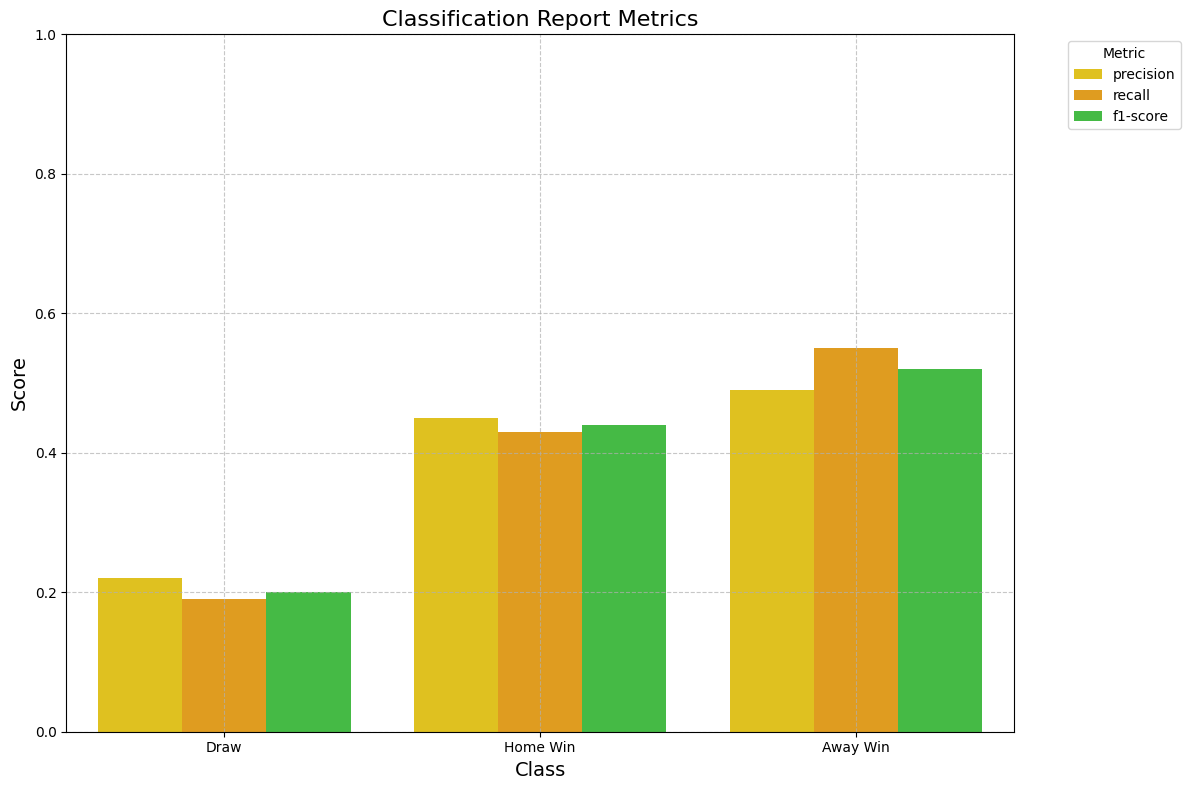

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming report_v1 is your classification report string

# Parse the classification report string into a DataFrame
report_df = pd.read_csv(StringIO(report_v1), delim_whitespace=True)

# Correcting the index to properly filter out 'accuracy', 'macro avg', and 'weighted avg'
report_df.index = ['Class 0', 'Class 1', 'Class 2', 'accuracy', 'macro avg', 'weighted avg']



# Extracting precision, recall, and F1-score for each class
metrics_df = report_df.loc[['Class 0', 'Class 1', 'Class 2'], ['precision', 'recall', 'f1-score']]




# Reset index for better plotting with seaborn
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Class'})

# Melt the DataFrame to long format for easier plotting with seaborn
metrics_melted = metrics_df.melt(id_vars='Class', var_name='Metric', value_name='Score')

# Plotting the metrics using seaborn with yellow, orange, and purple palette
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x='Class', y='Score', hue='Metric', palette=['gold', 'orange', 'limegreen'])

plt.gca().set_xticks(range(len(['Draw', 'Home Win', 'Away Win'])))
plt.gca().set_xticklabels(['Draw', 'Home Win', 'Away Win'])



# Enhancing the plot aesthetics
plt.title('Classification Report Metrics', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)  # Setting y-axis limit for better comparison
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adding legend outside the plot
plt.xticks(rotation=0)  # Ensuring class labels are readable
plt.grid(True, linestyle='--', alpha=0.7)  # Adding grid lines for clarity

# Displaying the plot
plt.tight_layout()  # Ensuring all elements fit within the figure area
plt.show()



In [232]:
# Create a DataFrame to display test data, true targets, predictions, and result of predictions
la_liga_2324_results = test.copy()

# Add a column for predictions made by the Random Forest Classifier
la_liga_2324_results['pred_rfc'] = preds_v1

# Create a column to indicate the outcome of each prediction
la_liga_2324_results['result_rfc'] = la_liga_2324_results.apply(lambda row: 'success' if row['target'] == row['pred_rfc'] else 'failure', axis=1)

# Select and rearrange columns as desired
la_liga_2324_results = la_liga_2324_results[['date', 'team', 'opponent', 'target', 'pred_rfc', 'result_rfc']]

# Display the first few rows of the results DataFrame
la_liga_2324_results.head()


,date,team,opponent,target,pred_rfc,result_rfc
570,2024-03-17,Celta Vigo,Sevilla,1,2,failure
571,2024-03-17,Villarreal,Valencia,1,1,success
572,2024-03-17,Sevilla,Celta Vigo,2,0,failure
573,2024-03-17,Barcelona,Atlético Madrid,1,2,failure
574,2024-03-17,Las Palmas,Almería,2,1,failure


In [233]:
# Save the results DataFrame to a CSV file if you wish to inspect further
la_liga_2324_results.to_csv('la_liga_2324_results.csv', index=False)

In [92]:
# ** Stage 4 ** Adding Additional Data/Features for ML to Improve Predictions
# Enhancing predictive power by incorporating new features specific to La Liga matches.

In [234]:
# Create a copy with increment ver of la_liga_2324 to preserve its integrity before adding new features.
# This ensures that any modifications do not affect the original DataFrame.
la_liga_2324_v1 = la_liga_2324.copy()
la_liga_2324_v1.head()
la_liga_2324.shape

(760, 22)

In [ ]:
# Calculate rolling averages for goals for, against & poss = (% of passes attempted, 
# It is an indicator of passing accuracy and efficiency)
# Rolling averages help capture trends over time, smoothing out short-term fluctuations.
# This is useful in machine learning models as it highlights the form of a team over recent matches,
# providing a better indication of future performance compared to individual match results.

In [235]:

# Before calculating rolling averages, group the matches by team to perform calculations per team.
grouped_matches = la_liga_2324_v1.groupby("team")


In [236]:
# Retrieve and display the matches data for the team "Barcelona" from the grouped DataFrame.
group = grouped_matches.get_group("Barcelona")
group.head()

,comp,season,round,date,time,day,team,opponent,venue,result,...,poss,attendance,captain,formation,referee,venue_code,opp_code,hour,day_code,target
10,La Liga,2023-2024,Matchweek 1,2023-08-13,21:30,Sun,Barcelona,Getafe,Away,D,...,74.0,13410.0,Marc-André ter Stegen,4-2-3-1,César Soto,0,8,21,6,0
32,La Liga,2023-2024,Matchweek 2,2023-08-20,19:30,Sun,Barcelona,Cádiz,Home,W,...,74.0,39603.0,Marc-André ter Stegen,3-4-3,Alejandro Muñíz,1,7,19,6,1
55,La Liga,2023-2024,Matchweek 3,2023-08-27,17:30,Sun,Barcelona,Villarreal,Away,W,...,60.0,21679.0,Sergi Roberto,4-3-3,Alejandro Hernández,0,19,17,6,1
73,La Liga,2023-2024,Matchweek 4,2023-09-03,21:00,Sun,Barcelona,Osasuna,Away,W,...,69.0,21966.0,Sergi Roberto,4-3-3,Miguel Ángel Ortiz Arias,0,13,21,6,1
86,La Liga,2023-2024,Matchweek 5,2023-09-16,21:00,Sat,Barcelona,Betis,Home,W,...,65.0,45055.0,Marc-André ter Stegen,4-3-3,José Sánchez,1,5,21,5,1


In [241]:
def rolling_averages(group, cols, new_cols):
    """
    Compute rolling averages for specified columns within each group (by team).

    Parameters:
    - group: DataFrame group for a specific team.
    - cols: List of columns to compute rolling averages for.
    - new_cols: List of new column names to assign to the rolling average results.

    Returns:
    - DataFrame with calculated rolling averages added as new columns.
    """
    group = group.sort_values("date")  # Sort the group data by 'date' for chronological order
    rolling_stats = group[cols].rolling(window=3, closed='left').mean()  # Calculate rolling averages for selected columns
    group[new_cols] = rolling_stats  # Assign calculated rolling averages to new columns in the DataFrame
    group = group.dropna(subset=new_cols)  # Drop rows with NaN values in the newly created columns
    return group


In [242]:
# Select columns for which rolling averages will be calculated
cols = ["gf", "ga", "poss"]

# Create new column names with '_rolling' suffix using list comprehension and f-string
new_cols = [f"{c}_rolling" for c in cols]

# Display the new column names
new_cols


['gf_rolling', 'ga_rolling', 'poss_rolling']

In [243]:
# Call the rolling_averages function to calculate rolling averages for selected columns
# Assign the results to new columns with '_rolling' suffix
group1 = rolling_averages(group, cols, new_cols)

# Display the first few rows of the updated DataFrame for selected team
group1.head()


,comp,season,round,date,time,day,team,opponent,venue,result,...,formation,referee,venue_code,opp_code,hour,day_code,target,gf_rolling,ga_rolling,poss_rolling
73,La Liga,2023-2024,Matchweek 4,2023-09-03,21:00,Sun,Barcelona,Osasuna,Away,W,...,4-3-3,Miguel Ángel Ortiz Arias,0,13,21,6,1,2.000000,1.000000,69.333333
86,La Liga,2023-2024,Matchweek 5,2023-09-16,21:00,Sat,Barcelona,Betis,Home,W,...,4-3-3,José Sánchez,1,5,21,5,1,2.666667,1.333333,67.666667
105,La Liga,2023-2024,Matchweek 6,2023-09-23,18:30,Sat,Barcelona,Celta Vigo,Home,W,...,4-3-3,Mario Melero,1,6,18,5,1,3.666667,1.333333,64.666667
120,La Liga,2023-2024,Matchweek 7,2023-09-26,21:30,Tue,Barcelona,Mallorca,Away,D,...,4-3-3,Alejandro Muñíz,0,12,21,1,0,3.333333,1.000000,69.333333
138,La Liga,2023-2024,Matchweek 8,2023-09-29,21:00,Fri,Barcelona,Sevilla,Home,W,...,4-3-3,Miguel Ángel Ortiz Arias,1,17,21,4,1,3.333333,1.333333,69.333333


In [244]:
# Apply the rolling_averages function to each team's data in la_liga_2324_v1 DataFrame
# This function calculates rolling averages for specified columns (cols) and assigns the results to new columns (new_cols)
la_liga_2324_v1 = la_liga_2324_v1.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))


In [245]:
# Drop the extra index level ('team') if multiple levels exist
la_liga_2324_v1 = la_liga_2324_v1.droplevel('team')


In [246]:
# Resetting the index to ensure unique values
la_liga_2324_v1.index = range(la_liga_2324_v1.shape[0])

# Note: The DataFrame now contains only 700 rows because the rolling average function 
# dropped the NA values from the first 3 games of each team. This is because we needed 
# at least 3 matches to calculate a 3-period rolling average.


In [247]:
la_liga_2324_v1.shape

(700, 25)

In [248]:
la_liga_2324_v1.head()

,comp,season,round,date,time,day,team,opponent,venue,result,...,formation,referee,venue_code,opp_code,hour,day_code,target,gf_rolling,ga_rolling,poss_rolling
0,La Liga,2023-2024,Matchweek 4,2023-09-02,18:30,Sat,Alaves,Valencia,Home,W,...,4-2-3-1,Pablo González,1,18,18,5,1,1.333333,1.666667,47.333333
1,La Liga,2023-2024,Matchweek 5,2023-09-15,21:00,Fri,Alaves,Rayo Vallecano,Away,L,...,4-2-3-1,Víctor García,0,14,21,4,2,1.666667,1.333333,42.333333
2,La Liga,2023-2024,Matchweek 6,2023-09-22,21:00,Fri,Alaves,Athletic Club,Home,L,...,4-2-3-1,Alejandro Muñíz,1,2,21,4,2,0.333333,1.000000,47.333333
3,La Liga,2023-2024,Matchweek 7,2023-09-28,19:00,Thu,Alaves,Celta Vigo,Away,D,...,4-2-3-1,César Soto,0,6,19,3,0,0.333333,1.333333,44.333333
4,La Liga,2023-2024,Matchweek 8,2023-10-01,16:15,Sun,Alaves,Osasuna,Home,L,...,4-2-3-1,Jorge Figueroa,1,13,16,6,2,0.333333,1.666667,49.000000


In [249]:
# Now, let's use Random Forest to see if adding the additional features
# (rolling averages) has improved the model's performance.

# First, save the DataFrame with all the rolling averages to a CSV file.
la_liga_2324_v1.to_csv('la_liga_2324_v1.csv', index=False)


In [250]:
# Load the DataFrame containing rolling averages from the CSV file to
# df with incremented ver
la_liga_2324_v1 = pd.read_csv('la_liga_2324_v1.csv')
la_liga_2324_v1.head()

,comp,season,round,date,time,day,team,opponent,venue,result,...,formation,referee,venue_code,opp_code,hour,day_code,target,gf_rolling,ga_rolling,poss_rolling
0,La Liga,2023-2024,Matchweek 4,2023-09-02,18:30,Sat,Alaves,Valencia,Home,W,...,4-2-3-1,Pablo González,1,18,18,5,1,1.333333,1.666667,47.333333
1,La Liga,2023-2024,Matchweek 5,2023-09-15,21:00,Fri,Alaves,Rayo Vallecano,Away,L,...,4-2-3-1,Víctor García,0,14,21,4,2,1.666667,1.333333,42.333333
2,La Liga,2023-2024,Matchweek 6,2023-09-22,21:00,Fri,Alaves,Athletic Club,Home,L,...,4-2-3-1,Alejandro Muñíz,1,2,21,4,2,0.333333,1.000000,47.333333
3,La Liga,2023-2024,Matchweek 7,2023-09-28,19:00,Thu,Alaves,Celta Vigo,Away,D,...,4-2-3-1,César Soto,0,6,19,3,0,0.333333,1.333333,44.333333
4,La Liga,2023-2024,Matchweek 8,2023-10-01,16:15,Sun,Alaves,Osasuna,Home,L,...,4-2-3-1,Jorge Figueroa,1,13,16,6,2,0.333333,1.666667,49.000000


In [251]:
# Importing the RandomForestClassifier from the sklearn.ensemble module

"""
Random Forest is a versatile and widely used machine learning algorithm known for its robustness and high performance in various predictive tasks.
It operates by constructing multiple decision trees during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Key Features:
- Ensemble Method: Aggregates predictions from multiple decision trees to improve accuracy and reduce overfitting.
- Versatility: Suitable for both classification and regression tasks.
- Robustness: Less prone to overfitting compared to individual decision trees.
- Feature Importance: Provides insights into which features are most influential for making predictions.

Random Forest is effective for complex datasets and can handle large amounts of data with high dimensionality, making it a popular choice in various domains.
"""

from sklearn.ensemble import RandomForestClassifier

In [253]:
# Initializing a RandomForestClassifier with specified parameters:
# n_estimators controls the number of decision trees in the forest (here set to 50).
# min_samples_split specifies the minimum number of samples required to split an internal node (set to 10).
# random_state sets the seed for random number generation to ensure reproducibility.
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

In [254]:
# Selecting predictors for the RandomForestClassifier model, including new rolling average features:
predictors_v2 = ["venue_code", "opp_code", "hour", "day_code", 'gf_rolling', 'ga_rolling', 'poss_rolling']


In [257]:
# Get the start and end date of the DataFrame
# Note that the dates are dynamic and will change as the DataFrame is filtered

season_start_date = la_liga_2324_v1['date'].min()
season_end_date = la_liga_2324_v1['date'].max()

# Display the start and end date of the season
print(f"Start Date: {season_start_date}")
print(f"End Date: {season_end_date}")

# Filter the DataFrame to include matches within the specified date range
season_data = la_liga_2324_v1[(la_liga_2324_v1['date'] >= season_start_date) & (la_liga_2324_v1['date'] <= season_end_date)]

# Calculate the index for the 75% split for training and testing data
split_index = int(len(season_data) * 0.75)

# Split the DataFrame into training and testing sets
train = season_data.iloc[:split_index]
test = season_data.iloc[split_index:]

# Define predictors and target variables
X_train = train[predictors_v2]
y_train = train["target"]
X_test = test[predictors_v2]
y_test = test["target"]

# Fit the RandomForestClassifier model on the training data
rf.fit(X_train, y_train)

# Make predictions using the trained model on the test data
preds_v2 = rf.predict(X_test)

from sklearn.metrics import accuracy_score

# Calculate accuracy score to evaluate the model performance
acc_v2 = accuracy_score(test["target"], preds_v2)

# Print predictions and accuracy score
print(preds_v2)
print(f"Accuracy Score: {acc_v2:.4f}")

# Display the length of predictions
length_preds_v2 = len(preds_v2)
print("Length of preds_v2:", length_preds_v2)


Start Date: 2023-09-01
End Date: 2024-05-26
[1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1
 1 1 1 1 1 2 2 2 1 1 1 1 2 1 2 2 1 2 1 2 1 1 2 1 1 1 2 1 1 2 1 2 2 1 0 1 2
 1 1 2 1 1 1 1 2 1 2 2 1 1 2 0 2 0 2 2 2 2 0 2 2 2 0 1 2 1 2 2 2 1 2 2 2 0
 0 2 1 2 0 2 2 2 2 2 0 2 0 1 2 2 2 2 2 0 2 2 1 2 0 1 2 1 2 2 1 2 1 1 1 0 2
 1 1 1 2 2 2 0 2 2 1 2 0 2 1 2 0 0 0 1 2 2 0 0 0 1 0 2]
Accuracy Score: 0.4457
Length of preds_v2: 175


In [258]:
# Create a DataFrame to compare actual and predicted values
combined_v2 = pd.DataFrame(dict(actual=test["target"], prediction=preds_v2))

# Generate a cross-tabulation to analyze the classification results
cross_tab_v2 = pd.crosstab(index=combined_v2['actual'], columns=combined_v2['prediction'])
cross_tab_v2


prediction,0,1,2
actual,,,
0,9,21,19
1,9,42,25
2,4,19,27


In [167]:
# classification report v2

# Extract actual and predicted values from combined_v2 DataFrame
actual_v2 = combined_v2['actual']
prediction_v2 = combined_v2['prediction']

# Generate the classification report with specified target names for clarity
report_v2 = classification_report(actual_v2, prediction_v2, target_names=['Class 0', 'Class 1', 'Class 2'])

# Print the classification report header
print("\nClassification Report:")

# Print the detailed classification report showing precision, recall, F1-score, and support for each class
print(report_v2)




Classification Report:
              precision    recall  f1-score   support

     Class 0       0.41      0.18      0.25        49
     Class 1       0.51      0.55      0.53        76
     Class 2       0.38      0.54      0.45        50

    accuracy                           0.45       175
   macro avg       0.43      0.43      0.41       175
weighted avg       0.45      0.45      0.43       175



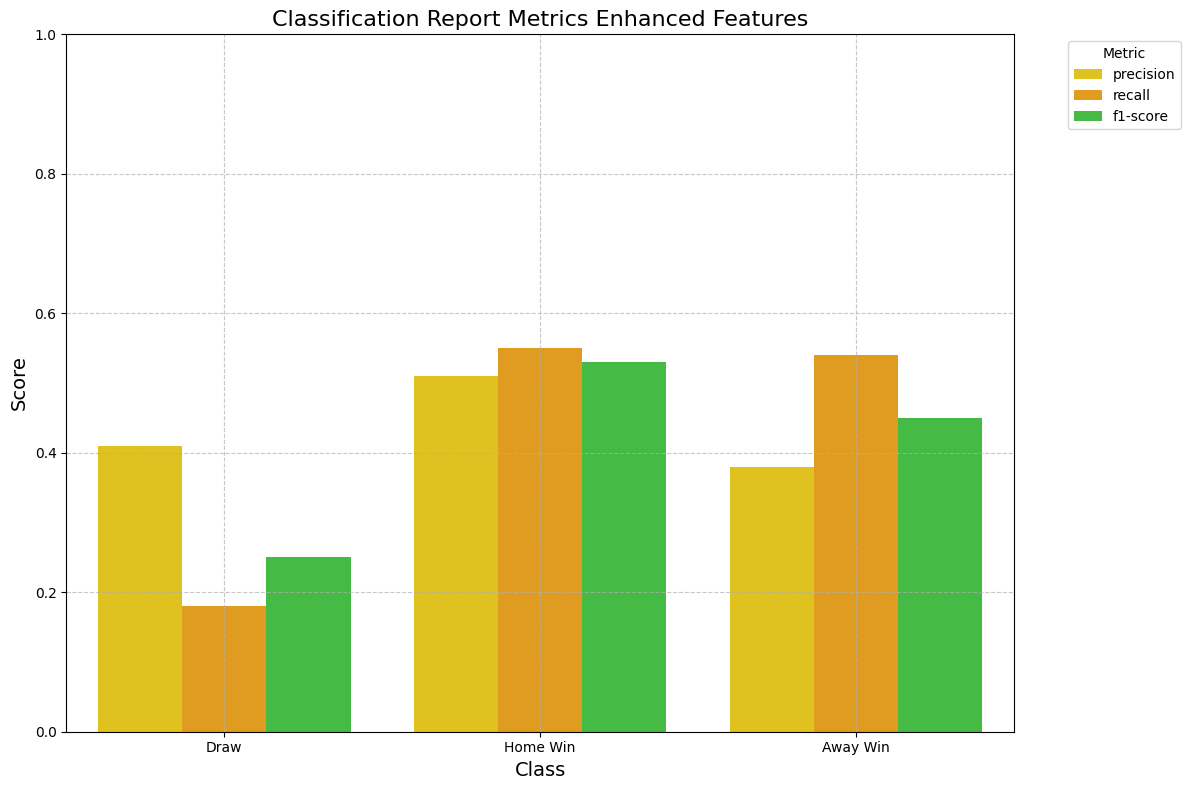

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# report_v2 is the classification report string

# Parse the string to a DataFrame
report_df = pd.read_csv(StringIO(report_v2), delim_whitespace=True)

# Correcting the index to properly filter out 'accuracy', 'macro avg', and 'weighted avg'
report_df.index = ['Class 0', 'Class 1', 'Class 2', 'accuracy', 'macro avg', 'weighted avg']
metrics_df = report_df.loc[['Class 0', 'Class 1', 'Class 2'], ['precision', 'recall', 'f1-score']]

# Reset index for better plotting with seaborn
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Class'})

# Melt the DataFrame for seaborn
metrics_melted = metrics_df.melt(id_vars='Class', var_name='Metric', value_name='Score')

# Plot the metrics using seaborn with custom palette
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x='Class', y='Score', hue='Metric', palette=['gold', 'orange', 'limegreen'])

plt.gca().set_xticks(range(len(['Draw', 'Home Win', 'Away Win'])))
plt.gca().set_xticklabels(['Draw', 'Home Win', 'Away Win'])


# Enhance the plot with titles, labels, and limits
plt.title('Classification Report Metrics Enhanced Features', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()



In [ ]:
# combine the 2 reports 

<Figure size 1400x800 with 0 Axes>

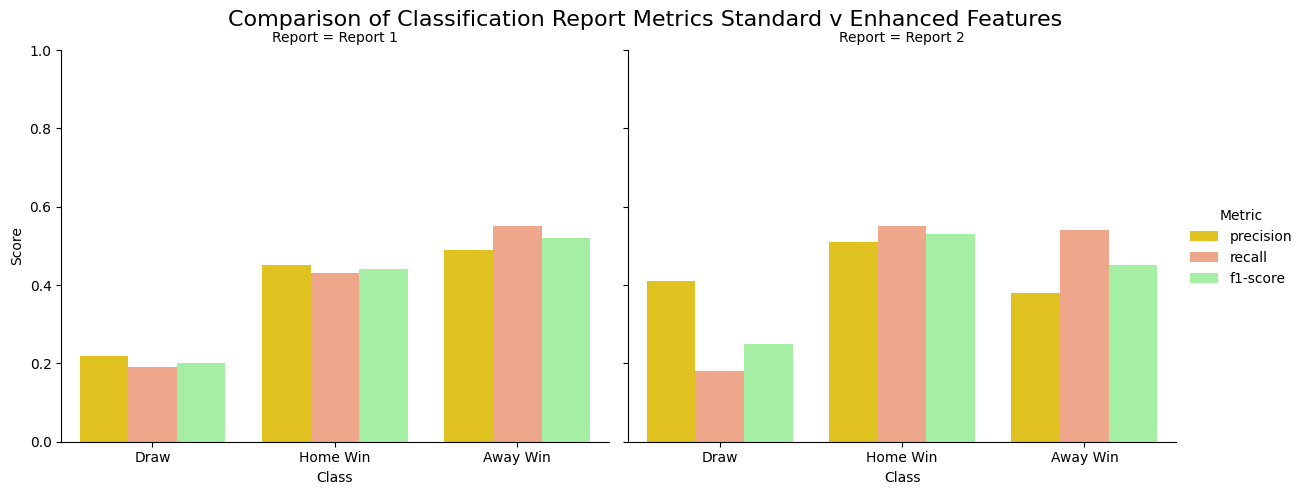

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# Assuming report_v1 and report_v2 are your classification report strings

# Parse the strings to DataFrames
report_df_v1 = pd.read_csv(StringIO(report_v1), delim_whitespace=True)
report_df_v2 = pd.read_csv(StringIO(report_v2), delim_whitespace=True)

# Correcting the index to properly filter out 'accuracy', 'macro avg', and 'weighted avg'
report_df_v1.index = ['Class 0', 'Class 1', 'Class 2', 'accuracy', 'macro avg', 'weighted avg']
report_df_v2.index = ['Class 0', 'Class 1', 'Class 2', 'accuracy', 'macro avg', 'weighted avg']

# Keep only the class-specific rows
metrics_df_v1 = report_df_v1.loc[['Class 0', 'Class 1', 'Class 2'], ['precision', 'recall', 'f1-score']]
metrics_df_v2 = report_df_v2.loc[['Class 0', 'Class 1', 'Class 2'], ['precision', 'recall', 'f1-score']]

# Add a column to distinguish between the reports
metrics_df_v1['Report'] = 'Report 1'
metrics_df_v2['Report'] = 'Report 2'

# Combine the DataFrames
combined_metrics_df = pd.concat([metrics_df_v1, metrics_df_v2])

# Reset index for better plotting with seaborn
combined_metrics_df = combined_metrics_df.reset_index().rename(columns={'index': 'Class'})

# Melt the DataFrame for seaborn
combined_metrics_melted = combined_metrics_df.melt(id_vars=['Class', 'Report'], var_name='Metric', value_name='Score')

# Define a custom vibrant color palette (yellow, orange, and green)
custom_palette = sns.color_palette(["#FFD700", "#FFA07A", "#98FB98", "#FF6347", "#FF69B4", "#40E0D0"])

# Plot the metrics using seaborn with the custom color palette
plt.figure(figsize=(14, 8))
sns.set_palette(custom_palette)  # Set the custom color palette
g = sns.catplot(data=combined_metrics_melted, x='Class', y='Score', hue='Metric', col='Report', kind='bar', height=5, aspect=1.2)

plt.gca().set_xticks(range(len(['Draw', 'Home Win', 'Away Win'])))
plt.gca().set_xticklabels(['Draw', 'Home Win', 'Away Win'])

# Enhance the plot
g.fig.subplots_adjust(top=0.9)  # Adjust the top to fit the title
g.fig.suptitle('Comparison of Classification Report Metrics Standard v Enhanced Features', fontsize=16)
for ax in g.axes.flat:
    ax.set_ylim(0, 1)  # y-axis shows the score values ranging from 0 to 1

plt.show()



In [261]:
# all the hard work comes down to this:
percent_increase = ((acc_v2 - acc_v1) / acc_v1) * 100
print(f"The original model accuracy score is {acc_v1:.4f}, while the model with enhanced features achieved {acc_v2:.4f}. This represents a {percent_increase:.2f}% increase from the original model.")

The original model accuracy score is 0.4211, while the model with enhanced features achieved 0.4457. This represents a 5.86% increase from the original model.


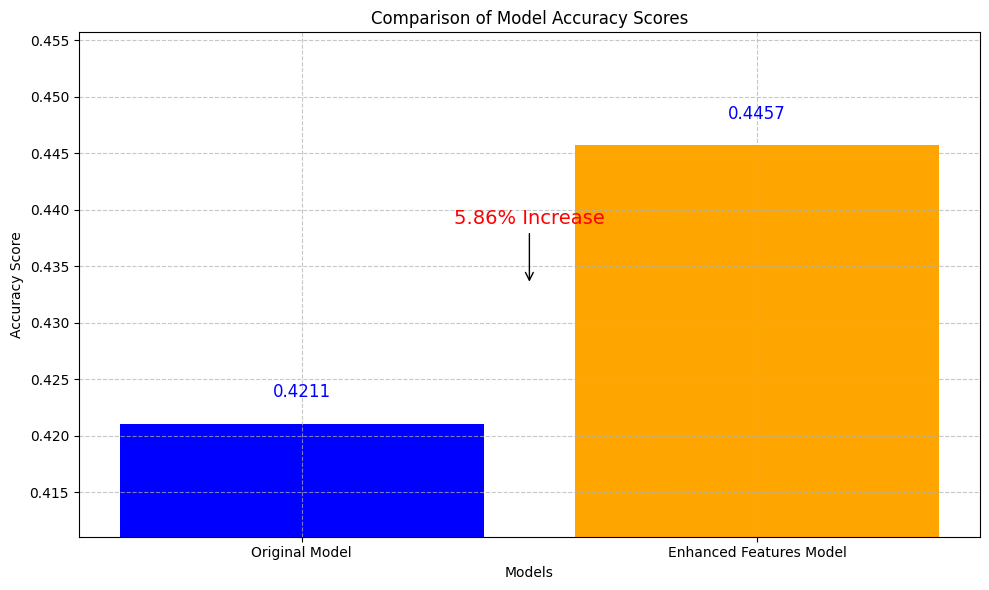

In [173]:
# The increase is only 5%, which might require a magnifying glass to see on a basic plot. Let's enhance 
# the visual for a clearer view. adjusting the y-axis scale effectively magnifies the difference in scores, 
#making the improvement more noticeable and impactful.


import matplotlib.pyplot as plt

# Data
models = ['Original Model', 'Enhanced Features Model']
scores = [acc_v1, acc_v2]
percent_increase = ((acc_v2 - acc_v1) / acc_v1) * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, scores, color=['blue', 'orange'])
plt.text(1, acc_v2 + 0.002, f'{acc_v2:.4f}', ha='center', va='bottom', fontsize=12, color='blue')
plt.text(0, acc_v1 + 0.002, f'{acc_v1:.4f}', ha='center', va='bottom', fontsize=12, color='blue')

# Highlight the increase with annotations
plt.annotate(f'{percent_increase:.2f}% Increase', xy=(0.5, (acc_v1 + acc_v2) / 2), xytext=(0.5, (acc_v1 + acc_v2) / 2 + 0.005),
             ha='center', va='bottom', fontsize=14, color='red',
             arrowprops=dict(facecolor='red', arrowstyle='->'))

# Labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Accuracy Scores')
plt.ylim(min(scores) - 0.01, max(scores) + 0.01)  # Adjusted y-axis limit to emphasize the difference
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [262]:
# Evaluating football match outcome predictions with a 44.5% accuracy in a 3-class scenario (win, lose, draw):
# 1. Above Random Chance: In a 3-class scenario (win, lose, draw), random guessing typically yields around 33% accuracy, 
# assuming equal probability for each outcome. However, in football predictions, matches often have clear favorites, 
# which means the actual baseline accuracy can be lower than 33%. 
# 2. Contextual Evaluation: Predicting football matches involves complex factors, making 44.5% accuracy meaningful.
# 3. Room for Improvement: Despite promise, further enhancements in features or algorithms could boost accuracy.
# 4. Benchmarking: Comparing against other methods helps gauge competitiveness and identifies areas to improve.
# Conclusion: While 44.5% accuracy shows predictive capability, ongoing refinement is essential for reliable predictions.


In [263]:
# Improving the model by ensuring all features are converted into numerical data for effective machine learning integration.
# This includes transforming features such as shots on target, weather data (temperature, humidity, precipitation), 
# cup game participation, player injuries/suspensions, home/away performance, and managerial changes into numerical formats.


# 1. Incorporate Shots on Target Data: Including statistics like shots on target per match could provide insights 
# into offensive efficiency and potentially enhance predictive accuracy.
# 2. Integrate Weather Data: Weather conditions during matches can impact player performance and game outcomes. 
# Incorporating weather data such as temperature, humidity, and precipitation may improve model robustness.
# 3. Consider Cup Game Participation: Teams participating in additional cup competitions may experience different
# levels of fatigue or prioritize differently, influencing their league performance. Including data on cup game participation could capture these dynamics.
# 4. Account for Player Injuries and Suspensions: Player availability due to injuries or suspensions significantly 
# affects team performance. Tracking player injuries and suspensions and incorporating this data into the model could 
# refine predictions.
# 5. Evaluate Home and Away Performance: Analyzing team performance differences between home and away matches can provide 
# valuable insights. Incorporating home and away statistics may better capture the nuances of team dynamics.
# 6. Include Managerial Changes: Changes in coaching staff or managerial strategies can impact team performance. 
# Monitoring managerial changes and their effects on team dynamics could contribute to more accurate predictions.

In [ ]:
# try alternative models 
# 1. Support Vector Machines (SVM):
#    - Explanation: SVMs find the hyperplane that best separates classes in feature space. They use kernel functions
#      for non-linear decision boundaries and are robust against overfitting, suitable for diverse datasets.

# 2. Multinomial Logistic Regression:
#    - Explanation: Logistic Regression extends to multi-class problems via multinomial variants. It models class
#      probabilities using the softmax function and predicts the class with the highest probability.

# 3. Gradient Boosting Classifier (e.g., XGBoost, LightGBM):
#    - Explanation: Gradient Boosting builds an ensemble of decision trees sequentially, where each corrects errors
#      of its predecessor. Models like XGBoost and LightGBM are known for high accuracy and handling complex data interactions.
